In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard
from datetime import datetime
from keras.layers import BatchNormalization


In [2]:
## Data preparation 
iris = load_iris()
Xraw = iris['data']
X=Xraw[:,2:4]
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=2)


n_features = X.shape[1]
n_classes = Y.shape[1]

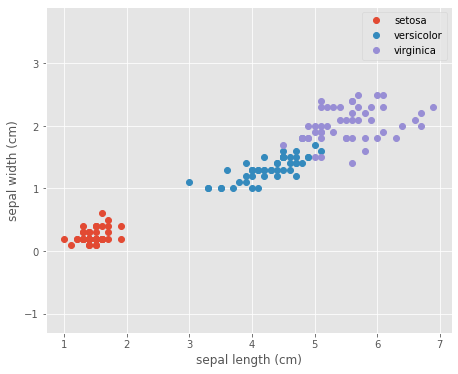

In [3]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

In [4]:
model = Sequential([Dense(8, input_dim=n_features, activation='relu'),
                    BatchNormalization(),
                    Dense(50, activation='relu'),
                    BatchNormalization(),
                    Dense(100, activation='relu'),
                    BatchNormalization(),
                    Dense(n_classes, activation='softmax')],
                    name='ANN')
model.compile(loss='mean_squared_error', 
                      optimizer='adam', 
                      metrics=['accuracy'])
model.summary();

Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                450       
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400     

In [5]:

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



print('Model name:', model.name)
history_callback = model.fit(X_train, y_train,
                                 batch_size=7,
                                 epochs=200,
                                 verbose=1,
                                 validation_data=(X_test, y_test),
                                 callbacks=[tensorboard_callback])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
history_dict = {}    
history_dict[model.name] = [history_callback, model]

Model name: ANN
Epoch 1/200
18/18 [==============================] - 1s 14ms/step - loss: 0.1327 - accuracy: 0.7250 - val_loss: 0.1876 - val_accuracy: 0.9000
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0647 - accuracy: 0.8667 - val_loss: 0.1737 - val_accuracy: 0.9000
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0645 - accuracy: 0.8750 - val_loss: 0.1605 - val_accuracy: 0.9000
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0653 - accuracy: 0.8667 - val_loss: 0.1456 - val_accuracy: 0.9000
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0573 - accuracy: 0.8917 - val_loss: 0.1315 - val_accuracy: 0.9000
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0511 - accuracy: 0.9167 - val_loss: 0.1173 - val_accuracy: 0.9000
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.9083 - val_loss: 0.0973 - val_accuracy: 0.9

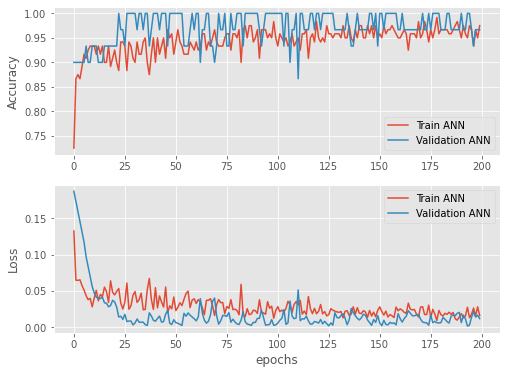

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    trn_acc = history_dict[model_name][0].history['accuracy']
    val_acc = history_dict[model_name][0].history['val_accuracy']
    trn_loss = history_dict[model_name][0].history['loss']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(trn_acc, label="Train "+ model_name)
    ax1.plot(val_acc, label="Validation "+model_name)
    ax2.plot(trn_loss, label="Train "+ model_name)
    ax2.plot(val_loss, label="Validation " + model_name)
    
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

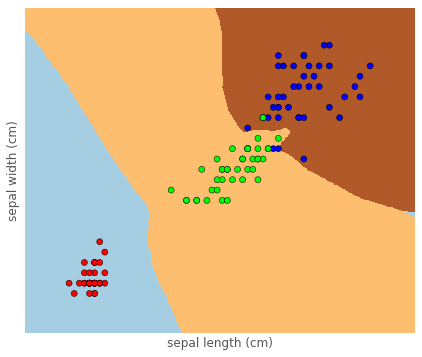

In [7]:
# X_train
XX=X_scaled*1
YY=Y

XX=X_train*1
YY=y_train
x_min, x_max = XX[:, 0].min() - .5, XX[:, 0].max() + .5
y_min, y_max = XX[:, 1].min() - .5, XX[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
sD=(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(model.predict(sD), axis=-1)
#Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(7, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired,shading='auto')
# Plot also the training points
plt.scatter(XX[:, 0], XX[:, 1], c=YY, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [8]:
print(YY.shape)

(120, 3)
